# Define the tools

In [1]:
# tools_drone.py
from __future__ import annotations
import asyncio, json, urllib.request, urllib.parse
from typing import Optional, Literal, Dict, Any

from langchain_core.tools import tool
# from Agentic_Controller_v4 import AgenticController  # v4  (keep as-is in your env)
from Agentic_Controller_v4 import AgenticController  # v4

# ------------------------- Globals / Singleton ctrl -------------------------
_CTRL: Optional[AgenticController] = None
_CTRL_LOCK = asyncio.Lock()

async def _get_ctrl() -> AgenticController:
    """Return a singleton AgenticController and ensure initial connection."""
    global _CTRL
    async with _CTRL_LOCK:
        if _CTRL is None:
            _CTRL = AgenticController()
            try:
                await _CTRL._ensure_connected()
            except Exception as e:
                print(f"[ctrl] connect warning: {e}")
        return _CTRL

# ------------------------------ HTTP helpers ------------------------------
def _http_get_json(url: str, query: Dict[str, Any] | None = None) -> Dict[str, Any]:
    """Simple blocking GET->JSON using urllib (no extra deps)."""
    if query:
        q = urllib.parse.urlencode(query)
        url = f"{url}?{q}" if "?" not in url else f"{url}&{q}"
    with urllib.request.urlopen(url, timeout=5) as resp:
        data = resp.read().decode("utf-8", errors="ignore")
        try:
            return json.loads(data)
        except json.JSONDecodeError:
            return {"ok": False, "error": "non_json_response", "raw": data}

# =============================== API Tools ================================

@tool("api_scene")
def api_scene() -> Dict[str, Any]:
    """Fetch the latest 3D detections from http://127.0.0.1:8088/scene"""
    return _http_get_json("http://127.0.0.1:8088/scene")

@tool("api_history")
def api_history() -> Dict[str, Any]:
    """Fetch the recent window of detections from http://127.0.0.1:8088/history"""
    return _http_get_json("http://127.0.0.1:8088/history")

@tool("api_take_photo")
def api_take_photo(tag: Optional[str] = None) -> Dict[str, Any]:
    """Trigger the camera to capture a frame now (http://127.0.0.1:8088/take_photo)."""
    q = {"tag": tag} if tag else None
    return _http_get_json("http://127.0.0.1:8088/take_photo", q)

@tool("api_sensors")
def api_sensors() -> Dict[str, Any]:
    """Fetch drone internal sensors from http://127.0.0.1:8001/sensors"""
    return _http_get_json("http://127.0.0.1:8001/sensors")

# ======================= Safety & Perception Helpers =======================

@tool("safety_gate")
def safety_gate(
    min_batt: float = 0.30,
    min_fix: str = "FIX_3D",
    min_rel_alt: float = 0.5,         # <- use relative altitude
    max_rel_alt: float = 120.0,
) -> Dict[str, Any]:
    """
    Check /sensors and return gate booleans + a recommended action.
    Returns: {"ok": bool, "gates": {...}, "recommend": "proceed|hold|rtl", "raw": {...}}
    """
    s = _http_get_json("http://127.0.0.1:8001/sensors")
    if not s or "battery" not in s:
        return {"ok": False, "error": "sensors_unavailable", "recommend": "hold"}

    remaining = s.get("battery", {}).get("remaining", 0)
    batt = (remaining / 100.0) if isinstance(remaining, (int, float)) else 0.0
    fix  = s.get("gps", {}).get("fix_type", "NO_FIX")

    # Support both shapes: top-level "position" or nested under "gps.position"
    pos_top   = s.get("position", {}) or {}
    pos_gps   = s.get("gps", {}).get("position", {}) or {}
    rel_alt   = pos_top.get("rel_alt_m", pos_gps.get("rel_alt_m", 0.0))

    gates = {
        "battery_ok": batt >= min_batt,
        "fix_ok": fix == min_fix,
        "altitude_ok": (float(min_rel_alt) <= float(rel_alt) <= float(max_rel_alt)),
        "armed": bool(s.get("status", {}).get("armed")),
        "in_air": bool(s.get("status", {}).get("in_air")),
        "flight_mode": s.get("status", {}).get("flight_mode", "UNKNOWN"),
    }

    if not gates["battery_ok"]:
        recommend = "rtl"
    elif not gates["fix_ok"]:
        recommend = "hold"
    else:
        recommend = "proceed"

    return {"ok": True, "gates": gates, "recommend": recommend, "raw": s}



@tool("perception_focus")
def perception_focus(label: str, min_conf: float = 0.6, top_k: int = 3) -> Dict[str, Any]:
    """
    Filter /scene for a specific label and return top-K hits with GPS if present.
    Returns: {"ok": True, "label": str, "hits": [{"conf":..,"gps":[lat,lon,alt],"time":..}], "count": int}
    """
    sc = _http_get_json("http://127.0.0.1:8088/scene")
    dets = sc.get("detections", []) or []
    hits = []
    for d in dets:
        name = d.get("Object Name") or d.get("label") or d.get("name")
        conf = float(d.get("Confidence", 0.0))
        if name == label and conf >= float(min_conf):
            g = d.get("estimated_global", {}) or {}
            hits.append({
                "conf": conf,
                "gps": [g.get("lat"), g.get("lon"), g.get("alt")],
                "center_m": d.get("Center", {}),
                "time": d.get("Time"),
            })
    hits.sort(key=lambda x: x["conf"], reverse=True)
    return {"ok": True, "label": label, "hits": hits[:top_k], "count": len(hits)}

@tool("goto_best_target")
async def goto_best_target(
    label: str,
    min_conf: float = 0.6,
    alt_abs_m: Optional[float] = None,     # keep None by default
    use_current_alt: bool = True           # NEW: default to current abs altitude
) -> Dict[str, Any]:
    """
    Choose the best target (by confidence) from perception_focus(label),
    then fly there using controller.goto(). Returns nav + target info.
    """
    sc = _http_get_json("http://127.0.0.1:8088/scene")
    dets = sc.get("detections", []) or []
    best = None
    for d in dets:
        name = d.get("Object Name") or d.get("label") or d.get("name")
        conf = float(d.get("Confidence", 0.0))
        if name == label and conf >= float(min_conf):
            g = d.get("estimated_global", {}) or {}
            if g.get("lat") is not None and g.get("lon") is not None:
                cand = {"conf": conf, "gps": [g.get("lat"), g.get("lon"), g.get("alt")]}
                if (best is None) or (cand["conf"] > best["conf"]):
                    best = cand
    if best is None:
        return {"ok": False, "error": "no_target"}

    lat, lon, est_alt = best["gps"]

    # Decide the absolute altitude to command:
    if alt_abs_m is not None:
        alt_cmd = float(alt_abs_m)
    elif use_current_alt:
        # Hold current absolute altitude from sensors
        s = _http_get_json("http://127.0.0.1:8001/sensors")
        pos_top = s.get("position", {}) or {}
        pos_gps = s.get("gps", {}).get("position", {}) or {}
        cur_abs = pos_top.get("abs_alt_m", pos_gps.get("abs_alt_m"))
        alt_cmd = float(cur_abs) if cur_abs is not None else None
    else:
        # Fall back to the estimated_global alt if present
        alt_cmd = float(est_alt) if est_alt is not None else None

    ctrl = await _get_ctrl()
    try:
        await ctrl.goto(lat, lon, alt_cmd)
        return {"ok": True, "target": {"label": label, "gps": [lat, lon, alt_cmd]},
                "status": "enroute_or_arrived"}
    except Exception as e:
        return {"ok": False, "error": f"goto_failed: {e}"}


# ============================ Flight/Move Tools ============================

@tool("takeoff")
async def t_takeoff(altitude_m: Optional[float] = None) -> Dict[str, Any]:
    """Take off to specified altitude (meters). Auto-connect+arm if needed."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.takeoff(altitude_m)
        return {"ok": True, "action": "takeoff", "alt_target_m": float(altitude_m or 3.0)}
    except Exception as e:
        return {"ok": False, "action": "takeoff", "error": str(e)}

@tool("land")
async def t_land() -> Dict[str, Any]:
    """Land the drone and disarm."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.land()
        return {"ok": True, "action": "land"}
    except Exception as e:
        return {"ok": False, "action": "land", "error": str(e)}

@tool("rtl")
async def t_rtl() -> Dict[str, Any]:
    """Return-to-launch (PX4 RTL)."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.rtl()
        return {"ok": True, "action": "rtl"}
    except Exception as e:
        return {"ok": False, "action": "rtl", "error": str(e)}

@tool("forward")
async def t_forward(meters: float) -> Dict[str, Any]:
    """Move forward in body frame."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.forward(float(meters))
        return {"ok": True, "action": "forward", "meters": float(meters)}
    except Exception as e:
        return {"ok": False, "action": "forward", "error": str(e)}

@tool("backward")
async def t_backward(meters: float) -> Dict[str, Any]:
    """Move backward in body frame."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.backward(float(meters))
        return {"ok": True, "action": "backward", "meters": float(meters)}
    except Exception as e:
        return {"ok": False, "action": "backward", "error": str(e)}

@tool("left")
async def t_left(meters: float) -> Dict[str, Any]:
    """Strafe left in body frame."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.left(float(meters))
        return {"ok": True, "action": "left", "meters": float(meters)}
    except Exception as e:
        return {"ok": False, "action": "left", "error": str(e)}

@tool("right")
async def t_right(meters: float) -> Dict[str, Any]:
    """Strafe right in body frame."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.right(float(meters))
        return {"ok": True, "action": "right", "meters": float(meters)}
    except Exception as e:
        return {"ok": False, "action": "right", "error": str(e)}

@tool("up")
async def t_up(meters: float) -> Dict[str, Any]:
    """Move up (NED -Z) in body frame."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.up(float(meters))
        return {"ok": True, "action": "up", "meters": float(meters)}
    except Exception as e:
        return {"ok": False, "action": "up", "error": str(e)}

@tool("down")
async def t_down(meters: float) -> Dict[str, Any]:
    """Move down (NED +Z) in body frame."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.down(float(meters))
        return {"ok": True, "action": "down", "meters": float(meters)}
    except Exception as e:
        return {"ok": False, "action": "down", "error": str(e)}

@tool("yaw_left")
async def t_yaw_left(degrees: float) -> Dict[str, Any]:
    """Rotate counter-clockwise by degrees (body yaw)."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.yaw_left(float(degrees))
        return {"ok": True, "action": "yaw_left", "degrees": float(degrees)}
    except Exception as e:
        return {"ok": False, "action": "yaw_left", "error": str(e)}

@tool("goto")
async def t_goto(lat: float, lon: float, alt_abs_m: Optional[float] = None) -> Dict[str, Any]:
    """Fly to GPS coordinates (absolute AMSL altitude)."""
    ctrl = await _get_ctrl()
    try:
        await ctrl.goto(float(lat), float(lon), (float(alt_abs_m) if alt_abs_m is not None else None))
        return {"ok": True, "action": "goto", "lat": float(lat), "lon": float(lon), "alt_abs_m": alt_abs_m}
    except Exception as e:
        return {"ok": False, "action": "goto", "error": str(e)}

@tool("orbit")
async def t_orbit(
    radius_m: float,
    direction: Literal["ccw", "cw"] = "cw",
    speed_mps: Optional[float] = None,
    return_to_center: bool = False,
) -> Dict[str, Any]:
    """Perform a 360° orbit around the current center with perimeter correction."""
    ctrl = await _get_ctrl()
    try:
        spd = float(speed_mps) if (speed_mps is not None) else 1.5
        await ctrl.orbit(float(radius_m), direction, spd, bool(return_to_center))
        return {
            "ok": True, "action": "orbit",
            "radius_m": float(radius_m), "direction": direction,
            "speed_mps": spd, "return_to_center": bool(return_to_center),
        }
    except Exception as e:
        return {"ok": False, "action": "orbit", "error": str(e)}

# ------------------------------ Tool registry ------------------------------
tools = [
    # APIs
    api_scene, api_history, api_take_photo, api_sensors,
    # Safety/Perception helpers
    safety_gate, perception_focus, goto_best_target,
    # Flight
    t_takeoff, t_land, t_rtl,
    t_forward, t_backward, t_left, t_right, t_up, t_down,
    t_yaw_left, t_goto, t_orbit,
]

# NOTE: Bind your LLM to tools in a later cell (agent construction).
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


# Planner design

In [2]:
# --- Planner node (LLM Supervisor) setup ---
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System prompt: UAV mission planner that chooses tools like a human pilot
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content="""

ROLE
You are the UAV Mission Planner for a PX4 X500 V2. Behave like a careful professional pilot:
Sense → Decide → Act → Observe → Verify, looping until the mission goal is satisfied.
If a mission remains unfulfilled after a reasonable number of steps (many tool calls) and no targets are found,
clearly report that the target was NOT DETECTED.

NON-UAV DIALOG
If the user message is unrelated to UAV operations (e.g., “hi”, “what’s my name?”), respond kindly and briefly
WITHOUT calling any tools.

STATE AWARENESS & RESUME
- Always infer context from prior thread/checkpoint; the drone may already be IN FLIGHT.
- Before any takeoff:
  • If status.in_air == true AND rel_alt_m ≥ 2.0: DO NOT take off again; continue at current altitude.
  • If armed and rel_alt_m < 2.0: climb to a safe hover (e.g., 2-4 m AGL).
  • If disarmed: take off only if the mission requires flight.
  • If you captured any object before taking off and and then some objects not visible maybe you need after takeoff if its 6m you need to go down to 3m to make it visible to your camera
  
- During approaches and GOTO, maintain the CURRENT ABSOLUTE ALTITUDE by default unless a different altitude is explicitly required.

SAFETY DOCTRINE (AVIATES FIRST)
- Before any risky action (arm, takeoff, goto, orbit, descend): call safety_gate() and FOLLOW its recommendation.
- Verify again with safety_gate() after each significant action.
- If safety_gate.recommend != "proceed": obey immediately (RTL/HOLD). Prefer RTL on low battery.
- Avoid collisions: when perception indicates nearby objects/close distances, adjust path or re-plan before continuing.

PERCEPTION POLICY
- Use perception_focus(label, min_conf) to evaluate the scene; prefer min_conf ≥ 0.7 for approach decisions.
- Re-check perception immediately before taking a photo to ensure the target is still present and reasonably centered.
- If available:
  • confirm_persistent_target(label) before approach (reduce false positives).
  • was_recently_photographed(lat,lon) to avoid duplicates; call mark_photographed(lat,lon) after a successful photo.
- If no target is present: rotate and search (e.g., yaw_left(45)) or perform a short, safe scan pattern; then re-check perception.

TOOL USE POLICY (ATOMIC STEPS, VERIFY BETWEEN)
- Prefer short, atomic calls with verification after each:
  safety_gate()
  perception_focus(label, min_conf[, top_k])
  goto_best_target(label, min_conf)      # keep current absolute altitude by default
  api_take_photo(tag)
  takeoff(altitude_m), rtl(), land()
  goto(lat, lon[, alt_abs_m])            # avoid alt_abs_m unless explicitly required
  yaw_left(degrees)
  forward()/backward()/left()/right()/up()/down(meters)
  orbit(...)
- If available: ready_for_photo() just before taking a photo; if not OK, stabilize (hover/yaw/short move), then try again.

EVENTS & DECISIONS
- When perception finds a valid target: INTERRUPT search → goto_best_target → verify target again →
  (optional ready_for_photo) → take photo → log short status → resume mission.
- When no target is found: continue yaw/search and re-evaluate perception.
- Always log progress in a concise operator style (below).

OUTPUT STYLE — OPERATOR LOG (REALISTIC, NO RAW JSON)
Emit short, one-sentence lines like a human pilot’s log. Do NOT include raw JSON in normal logs.
Use these labels:
  🧠 PLAN: <intent in one line>
  👀 SENSE: <what you checked + key values, e.g., batt 96%, GPS 3D, alt 5m>
  🛠️ ACT: <what you executed, e.g., takeoff 5m; goto (47.39675, 8.54976) @ ~8m>
  📡 OBSERVE: <salient outcome in words (no raw JSON)>
  📷 RESULT: <filename>   # for photos only
  ✅ VERIFY: <safety/perception outcome in one line>
  ⚠️ EVENT: <concise issue>   # e.g., battery low, GPS degraded
Only the following may be JSON:
  STATUS: {"next":"continue"}
  MISSION_SUMMARY: {"status":"...", "photos":[...], "coverage":"...", "notes":"..."}

RUN CONTROL (MULTI-STEP)
- Use as many tool calls as needed across turns, but keep each turn focused.
- If more steps are needed, emit exactly: STATUS: {"next":"continue"}  (NO tool calls in that message).
- When fully finished (or safely aborted), emit exactly:
  MISSION_SUMMARY: {"status":"...", "photos":[...], "coverage":"...", "notes":"..."}  (NO tool calls).

GUARDS
- Never call takeoff if already in_air and rel_alt_m ≥ 2.0.
- Before a photo, ensure the target is still visible unless explicitly waived.
- If user instructions conflict with safety_gate, follow safety_gate.
- For survey/search missions, routinely use yaw_left(45) to widen coverage before re-checking perception.
- Avoid specifying alt_abs_m unless explicitly required; by default maintain current absolute altitude on approaches.

TOOLS AVAILABLE
api_sensors, api_scene, api_history, api_take_photo,
safety_gate, perception_focus, goto_best_target,
takeoff, land, rtl, goto, orbit,
forward, backward, left, right, up, down, yaw_left


""")


# Planner node: LLM bound to the drone tools; returns the next assistant message
def planner(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph and Workflow Design

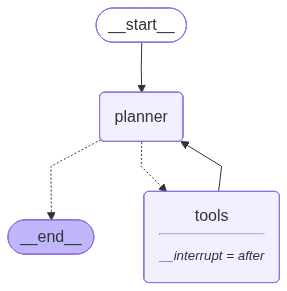

In [3]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MessagesState)

# Nodes
builder.add_node("planner", planner)          # LLM Supervisor
builder.add_node("tools", ToolNode(tools))    # Deterministic tool node

# Edges
builder.add_edge(START, "planner")
builder.add_conditional_edges("planner", tools_condition)  # to tools or END
builder.add_edge("tools", "planner")
memory = MemorySaver()

uav_graph_step = builder.compile(
    checkpointer=memory,
    interrupt_after=["tools"],   # ⬅️ pause after each tool call
)
# Visualize
display(Image(uav_graph_step.get_graph(xray=True).draw_mermaid_png()))


In [4]:
# ===== Colab: Mission Prompt API (FastAPI) =====
# Installs (safe to rerun)
!pip -q install fastapi uvicorn nest_asyncio pydantic

import asyncio, uuid, json, re, time
from typing import Any, Dict, List, Optional

import nest_asyncio
nest_asyncio.apply()

from fastapi import FastAPI, WebSocket, WebSocketDisconnect, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import uvicorn

# ---- Import your LangGraph / message types already in the kernel ----
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

# Reuse your helpers / prefixes from the mission driver
OPLOG_PREFIXES = ("🧠","👀","🛠️","📡","📷","✅","⚠️","STATUS","MISSION_SUMMARY")

def _parse_json_after_prefix(prefix: str, text: str) -> Optional[Dict[str, Any]]:
    if not text:
        return None
    m = re.search(rf"(?m)^\s*{re.escape(prefix)}\s*:\s*(\{{.*\}})\s*$", (text or "").strip())
    if not m:
        return None
    try:
        return json.loads(m.group(1))
    except Exception:
        return None

def _ai_has_oplog_lines(ai: AIMessage) -> bool:
    c = (ai.content or "")
    return any(line.strip().startswith(OPLOG_PREFIXES) for line in c.splitlines())

def _is_tool_call(ai: AIMessage) -> bool:
    return bool(getattr(ai, "tool_calls", None))

# ---- Async generator that yields events as the mission progresses ----
async def run_mission_stream(start_cmd: str, max_steps: int = 500):
    """Yield structured events during mission execution."""
    state = {"messages": [HumanMessage(content=start_cmd)]}
    last_len = 0
    photos: List[str] = []
    consecutive_plain_ai = 0

    for step in range(max_steps):
        result = await uav_graph_step.ainvoke(state, config)
        msgs = result["messages"]
        new_msgs = msgs[last_len:]

        # Stream new message content as events
        for m in new_msgs:
            if isinstance(m, AIMessage):
                # Stream only operator-log style lines
                content = (m.content or "").strip()
                if content:
                    for line in content.splitlines():
                        if line.strip().startswith(OPLOG_PREFIXES):
                            yield {"type": "oplog", "line": line.strip(), "t": time.time()}
            elif isinstance(m, ToolMessage):
                # Only announce photos (keep other JSON quiet)
                name = getattr(m, "name", "")
                raw = (m.content or "").strip()
                if name == "api_take_photo":
                    try:
                        d = json.loads(raw)
                        if isinstance(d, dict) and d.get("status") in ("ok", "success") and d.get("file"):
                            photos.append(d["file"])
                            yield {"type": "photo", "file": d["file"], "t": time.time()}
                    except Exception:
                        pass

        last_len = len(msgs)
        last = msgs[-1] if msgs else None

        if isinstance(last, AIMessage):
            # A) Tool pending → continue
            if _is_tool_call(last):
                state["messages"] = msgs
                continue

            # B) STATUS tick
            status = _parse_json_after_prefix("STATUS", last.content or "")
            if status:
                yield {"type": "status", "status": status, "t": time.time()}
                state["messages"] = msgs
                continue

            # C) Mission summary → finish
            summary = _parse_json_after_prefix("MISSION_SUMMARY", last.content or "")
            if summary:
                if photos and isinstance(summary.get("photos"), list):
                    summary["photos"] = list({*summary["photos"], *photos})
                yield {"type": "summary", "summary": summary, "messages_count": len(msgs), "t": time.time()}
                return

            # D) Plain chat (no tools, no STATUS/SUMMARY) → stop after 1
            if not _ai_has_oplog_lines(last):
                yield {"type": "plain_reply", "text": (last.content or ""), "t": time.time()}
                return

        # Default: keep looping
        state["messages"] = msgs

    # If we ever get here, we exceeded the step budget
    raise RuntimeError("Mission exceeded max_steps without emitting MISSION_SUMMARY or plain reply.")

# ---- In-memory mission registry ----
class StartBody(BaseModel):
    prompt: str
    max_steps: int = 500

missions: Dict[str, Dict[str, Any]] = {}  # id -> {status, events, summary, error, task}

# ---- FastAPI app ----
app = FastAPI(title="UAV Mission Prompt API", version="1.0.0")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # tighten for production
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.get("/health")
def health():
    return {"ok": True}

@app.post("/mission/start")
async def start_mission(body: StartBody):
    # Basic sanity: make sure the LangGraph is compiled
    if "uav_graph_step" not in globals():
        raise HTTPException(status_code=500, detail="uav_graph_step not found. Compile your graph first.")

    mid = str(uuid.uuid4())
    missions[mid] = {
        "status": "running",
        "events": [],
        "summary": None,
        "error": None,
        "prompt": body.prompt,
        "started": time.time(),
        "max_steps": body.max_steps,
    }

    async def _worker():
        try:
            async for ev in run_mission_stream(body.prompt, max_steps=body.max_steps):
                missions[mid]["events"].append(ev)
                if ev.get("type") == "summary":
                    missions[mid]["summary"] = ev["summary"]
                    missions[mid]["status"] = "done"
            if missions[mid]["status"] != "done":
                missions[mid]["status"] = "done"
        except Exception as e:
            missions[mid]["status"] = "error"
            missions[mid]["error"] = str(e)

    missions[mid]["task"] = asyncio.create_task(_worker())
    return {"mission_id": mid, "status": missions[mid]["status"]}

@app.get("/mission/{mid}/status")
def mission_status(mid: str):
    m = missions.get(mid)
    if not m:
        raise HTTPException(status_code=404, detail="Mission not found")
    return {
        "status": m["status"],
        "events_count": len(m["events"]),
        "has_summary": m["summary"] is not None,
        "error": m["error"],
        "prompt": m["prompt"],
        "started": m["started"],
    }

@app.get("/mission/{mid}/events")
def mission_events(mid: str, from_: int = 0):
    """Poll new events from a given index (for dashboards without websockets)."""
    m = missions.get(mid)
    if not m:
        raise HTTPException(status_code=404, detail="Mission not found")
    events = m["events"]
    start = max(0, int(from_))
    return {"from": start, "to": len(events), "events": events[start:], "status": m["status"]}

@app.get("/mission/{mid}/summary")
def mission_summary(mid: str):
    m = missions.get(mid)
    if not m:
        raise HTTPException(status_code=404, detail="Mission not found")
    if m["summary"] is None and m["status"] == "running":
        return {"status": "running", "summary": None}
    if m["status"] == "error":
        return {"status": "error", "error": m["error"]}
    return {"status": m["status"], "summary": m["summary"]}

@app.websocket("/ws/mission/{mid}")
async def mission_ws(websocket: WebSocket, mid: str):
    m = missions.get(mid)
    if not m:
        # Accept then send error once to keep client simple
        await websocket.accept()
        await websocket.send_text(json.dumps({"type": "error", "message": "Mission not found"}))
        await websocket.close()
        return

    await websocket.accept()
    last = 0
    try:
        while True:
            # Push any new events
            events = m["events"]
            if last < len(events):
                for ev in events[last:]:
                    await websocket.send_text(json.dumps(ev))
                last = len(events)

            # If done, also push a terminal message then close
            if m["status"] in ("done", "error"):
                if m["status"] == "error":
                    await websocket.send_text(json.dumps({"type": "error", "message": m["error"]}))
                else:
                    await websocket.send_text(json.dumps({"type": "done"}))
                await websocket.close()
                return

            # Keepalive
            await asyncio.sleep(0.25)
    except WebSocketDisconnect:
        return

# ---- Launch the server on 0.0.0.0:8003 (Colab-friendly) ----
def _run():
    uvicorn.run(app, host="0.0.0.0", port=8005, log_level="info")

import threading
server_thread = threading.Thread(target=_run, daemon=True)
server_thread.start()

print("✅ Mission Prompt API running on http://localhost:8003")


✅ Mission Prompt API running on http://localhost:8003


INFO:     Started server process [2170575]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8005 (Press CTRL+C to quit)


INFO:     127.0.0.1:42204 - "POST /mission/start HTTP/1.1" 200 OK
INFO:     127.0.0.1:42206 - "GET /mission/91561a04-2542-4594-a7eb-b7034705813e/events?from=0?from=0 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42212 - "GET /mission/91561a04-2542-4594-a7eb-b7034705813e/summary HTTP/1.1" 200 OK


In [5]:
'''
# === Mission driver (pause-after-tool, resumable, operator-log output) ===
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
import asyncio, json, re
from typing import Any, Dict

# 1) Compile the step graph (pauses after each tool)
memory = MemorySaver()
uav_graph_step = builder.compile(
    checkpointer=memory,
    interrupt_after=["tools"],   # one atomic tool step per ainvoke()
)

# 2) Thread config (persistent state across turns)
config = {
    "configurable": {"thread_id": "uav-thread-1"},
    "recursion_limit": 200,
}

# 3) Helpers
OPLOG_PREFIXES = ("🧠","👀","🛠️","📡","📷","✅","⚠️","STATUS","MISSION_SUMMARY")

def _parse_json_after_prefix(prefix: str, text: str) -> Dict[str, Any] | None:
    """Extract JSON object from a line like: PREFIX: {...}"""
    if not text:
        return None
    m = re.search(rf"(?m)^\s*{re.escape(prefix)}\s*:\s*(\{{.*\}})\s*$", text.strip())
    if not m:
        return None
    try:
        return json.loads(m.group(1))
    except Exception:
        return None

def _ai_has_oplog_lines(ai: AIMessage) -> bool:
    c = (ai.content or "")
    return any(line.strip().startswith(OPLOG_PREFIXES) for line in c.splitlines())

def _pretty_ai(msg: AIMessage):
    c = (msg.content or "").strip()
    if not c:
        return
    for line in c.splitlines():
        if line.strip().startswith(OPLOG_PREFIXES):
            print(line.strip())

def _pretty_tool(msg: ToolMessage):
    """Only surface human-friendly outputs (hide raw JSON)."""
    name = getattr(msg, "name", "")
    raw = (msg.content or "").strip()
    # Only special-case camera output for the audience
    if name == "api_take_photo":
        try:
            d = json.loads(raw)
            if isinstance(d, dict) and d.get("status") in ("ok", "success") and d.get("file"):
                print(f"📷 RESULT: {d['file']}")
                return
        except Exception:
            pass
    # Otherwise, keep tool output quiet to avoid JSON spam in demos.
    # (If you want debug, add a DEBUG flag and print a short snippet here.)

def _is_tool_call(ai: AIMessage) -> bool:
    return bool(getattr(ai, "tool_calls", None))

# 4) Driver loop
START_CMD = "can you search for car and capture them and count how many?"  # try a non-UAV prompt or a mission

async def run_mission(start_cmd: str, max_steps: int = 500):
    state = {"messages": [HumanMessage(content=start_cmd)]}
    last_len = 0
    photos = []
    consecutive_plain_ai = 0  # counts turns with plain chat/no tools

    for step in range(max_steps):
        result = await uav_graph_step.ainvoke(state, config)

        msgs = result["messages"]
        new_msgs = msgs[last_len:]

        for m in new_msgs:
            if isinstance(m, AIMessage):
                _pretty_ai(m)
            elif isinstance(m, ToolMessage):
                _pretty_tool(m)
                # capture photo artifacts optionally for your own post-processing
                if getattr(m, "name", "") == "api_take_photo":
                    try:
                        d = json.loads(m.content)
                        if isinstance(d, dict) and d.get("status") in ("ok", "success") and d.get("file"):
                            photos.append(d["file"])
                    except Exception:
                        pass

        last_len = len(msgs)
        last = msgs[-1] if msgs else None

        if isinstance(last, AIMessage):
            # A) Tool scheduled? Continue next step.
            if _is_tool_call(last):
                consecutive_plain_ai = 0
                state["messages"] = msgs
                continue

            # B) STATUS / SUMMARY?
            status = _parse_json_after_prefix("STATUS", last.content or "")
            if status:
                consecutive_plain_ai = 0
                state["messages"] = msgs
                continue

            summary = _parse_json_after_prefix("MISSION_SUMMARY", last.content or "")
            if summary:
                # merge photos (optional)
                if photos and isinstance(summary.get("photos"), list):
                    summary["photos"] = list({*summary["photos"], *photos})
                print("\n=== MISSION DONE ===")
                print(json.dumps(summary, indent=2, ensure_ascii=False))
                return result

            # C) Plain chat or operator text with no tools?
            # If the AI emitted no tool call and no STATUS/SUMMARY,
            # stop after one such turn (plain chat case) to avoid infinite loop.
            if not _ai_has_oplog_lines(last):
                consecutive_plain_ai += 1
                if consecutive_plain_ai >= 1:
                    # End gracefully for non-UAV dialog or a single summary-like reply
                    return result
            else:
                consecutive_plain_ai = 0

        # D) Fallback: continue by default
        state["messages"] = msgs

    raise RuntimeError("Mission exceeded max_steps without emitting MISSION_SUMMARY or plain reply.")

# 5) Run it
final = await run_mission(START_CMD)
'''

'\n# === Mission driver (pause-after-tool, resumable, operator-log output) ===\nfrom langchain_core.messages import HumanMessage, AIMessage, ToolMessage\nfrom langgraph.checkpoint.memory import MemorySaver\nimport asyncio, json, re\nfrom typing import Any, Dict\n\n# 1) Compile the step graph (pauses after each tool)\nmemory = MemorySaver()\nuav_graph_step = builder.compile(\n    checkpointer=memory,\n    interrupt_after=["tools"],   # one atomic tool step per ainvoke()\n)\n\n# 2) Thread config (persistent state across turns)\nconfig = {\n    "configurable": {"thread_id": "uav-thread-1"},\n    "recursion_limit": 200,\n}\n\n# 3) Helpers\nOPLOG_PREFIXES = ("🧠","👀","🛠️","📡","📷","✅","⚠️","STATUS","MISSION_SUMMARY")\n\ndef _parse_json_after_prefix(prefix: str, text: str) -> Dict[str, Any] | None:\n    """Extract JSON object from a line like: PREFIX: {...}"""\n    if not text:\n        return None\n    m = re.search(rf"(?m)^\\s*{re.escape(prefix)}\\s*:\\s*(\\{{.*\\}})\\s*$", text.strip())\n  